<a href="https://colab.research.google.com/github/annugoyall/Complaint_Classification/blob/main/Complaint_Classification_using_ML_Based_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import string

import nltk
! pip install rake_nltk
from rake_nltk import Metric, Rake
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

from textblob import TextBlob , Word

from collections import OrderedDict
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

### Reading CSV file and renaming the headers

In [ ]:
df = pd.read_csv("Samples_50.csv")
E = np.array(df['Emails'])
X_train , X_test = train_test_split(E , test_size = 0.2)
df_train = pd.DataFrame(X_train,columns=['Email'])
df_test = pd.DataFrame(X_test,columns=['Email'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   40 non-null     object
dtypes: object(1)
memory usage: 448.0+ bytes


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes


# Text preprocessing 

##### It is the process of removing unnecessary details from the data to make it clean for further analysis.
##### The raw data consists of unnecessary details like contact numbers, email ids, names of customers and addresses which are not relevant to our problem statement. The following noise reduction steps were performed:
##### Step 1 :  Numerics and Email Id removal :- Numeric Data in the form of Consignment Numbers, Tracking Ids, dates, and monetary amounts. Email Id for reference of prior complaints or tracking parcels. 

###### On training data

In [ ]:
df_train["numerics_removal"] = df_train["Email"].str.replace("\d+","")
df_train["emailid_removal"] = df_train["numerics_removal"].str.replace("\S+@\S+","")

###### On testing data

In [ ]:
df_test["numerics_removal"] = df_test["Email"].str.replace("\d+","")
df_test["emailid_removal"] = df_test["numerics_removal"].str.replace("\S+@\S+","")

##### Step 2: Removal of Custom Punctuations :-  All punctuations except ‘!’ , ’?’ were removed from the data. A sentence ending with an exclamation mark ‘!’  expresses a strong emotion, majorly negative in sentiment.  A question mark ‘?’ is indicative of an interrogative or demanding sentiment. 

###### On training data

In [ ]:
p = string.punctuation 
p = p[:p.find('!')] + p[p.find('!')+1 : p.find('?')] +  p[p.find('?')+1:]
def remove_punctuation(text):
    return text.translate((str.maketrans(p, ' ' * len(p))))
df_train["Email_punct"] = df_train["emailid_removal"].apply(remove_punctuation)

###### On testing data

In [ ]:
p = string.punctuation
p = p[:p.find('!')] + p[p.find('!')+1 : p.find('?')] +  p[p.find('?')+1:]
def remove_punctuation(text):
    return text.translate((str.maketrans(p, ' ' * len(p))))
df_test["Email_punct"] = df_test["emailid_removal"].apply(remove_punctuation)

##### Step 3:  Removal of Stopwords :- All stray single characters and stopwords were removed. The basic NLTK list of stopwords, was customized so that the words like ‘no’, ‘not’ etc. will not be removed, which are relevant to the problem statement.

###### On training data

In [ ]:
df_train['letter_removal'] = df_train['Email_punct'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "would", "dear", "hi", "rd" , "th" , "rs" , "cc" , "re", "fw", "pm", "sir", "madam"]
def rem(t):
    if t.lower() in stop_words:
        return ""
    return t
def k(s):
    r  = ""
    for t in s.split():
        val = rem(t)
        if val !="":
            r += val + " "
    return r
df_train["stopwords_removal"] = df_train["letter_removal"].apply(k)

###### On testing data

In [ ]:
df_test['letter_removal'] = df_test['Email_punct'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "would", "dear", "hi", "rd" , "th" , "rs" , "cc" , "re", "fw", "pm", "sir", "madam"]
def rem(t):
    if t.lower() in stop_words:
        return ""
    return t
def k(s):
    r  = ""
    for t in s.split():
        val = rem(t)
        if val !="":
            r += val + " "
    return r
df_test["stopwords_removal"] = df_test["letter_removal"].apply(k)

##### Deleting unnecessary columns

In [ ]:
# From training data
df_train.drop(['numerics_removal' ,'emailid_removal' , 'Email_punct'] , inplace = True , axis = 1)

# From testing data
df_test.drop(['numerics_removal' ,'emailid_removal' , 'Email_punct'] , inplace = True , axis = 1)

# Features Extraction

#### Once the data is cleaned, the remaining text is grouped into key phrases and their priority with respect to the problem statement (in our case, complaints) is checked and they are allotted weights in order to classify them into relevant groups

#### This can be done in following ways:- NGram , Tf-Idf , Rake

## N-Grams
###### The sentences can be grouped in unigrams, bigrams, trigrams and so on and the frequency of the keyphrases are checked to identify the top keyphrases for classification. 

##### Bigrams

In [ ]:
def find_ngrams(input_sequence):
    n = 2
    # Split sentence into tokens.
    tokens = input_sequence.split()
    ngrams = []
    for i in range(0 , len(tokens) , n):
        # Take n consecutive tokens in array.
        ngram = tokens[i:i+n]
        # Concatenate array items into string.
        ngram = ' '.join(ngram)
        ngrams.append(ngram)
    return ngrams
bi = df_train['letter_removal'].apply(find_ngrams)

In [ ]:
def find_ngrams(input_sequence):
    n = 3
    # Split sentence into tokens.
    tokens = input_sequence.split()
    ngrams = []
    for i in range(0 , len(tokens) , n):
        # Take n consecutive tokens in array.
        ngram = tokens[i:i+n]
        # Concatenate array items into string.
        ngram = ' '.join(ngram)
        ngrams.append(ngram)
    return ngrams
tri = df_train['letter_removal'].apply(find_ngrams)

In [ ]:
def find_ngrams(input_sequence):
    n = 4
    # Split sentence into tokens.
    tokens = input_sequence.split()
    ngrams = []
    for i in range(0 , len(tokens) , n):
        # Take n consecutive tokens in array.
        ngram = tokens[i:i+n]
        # Concatenate array items into string.
        ngram = ' '.join(ngram)
        ngrams.append(ngram)
    return ngrams
tetra = df_train['letter_removal'].apply(find_ngrams)

In [ ]:
print("Some of the bigrams are :")
print(bi[:5])
print("\n\nSome of the trigrams are :")
print(tri[:5])
print("\n\nSome of the tetragrams are :")
print(tetra[:5])

Some of the bigrams are :
0    [DEAR SIR, MY PARENT, BOOKED SOME, WEDDING CAR...
1    [MY courier, had been, dispatched on, from ahm...
2    [Content hand, over ed, to DTDC, courier servi...
3    [This is, mail am, shooting out, for very, bad...
4    [have consignment, from Orissa, on rd, March t...
Name: letter_removal, dtype: object


Some of the trigrams are :
0    [DEAR SIR MY, PARENT BOOKED SOME, WEDDING CARD...
1    [MY courier had, been dispatched on, from ahme...
2    [Content hand over, ed to DTDC, courier servic...
3    [This is mail, am shooting out, for very bad, ...
4    [have consignment from, Orissa on rd, March to...
Name: letter_removal, dtype: object


Some of the tetragrams are :
0    [DEAR SIR MY PARENT, BOOKED SOME WEDDING CARD,...
1    [MY courier had been, dispatched on from ahmed...
2    [Content hand over ed, to DTDC courier service...
3    [This is mail am, shooting out for very, bad e...
4    [have consignment from Orissa, on rd March to,...
Name: letter_remo

## Rake
#### RAKE splits the text into sentences and generates candidate phrases based on user- defined parameters. RAKE uses a list of stopwords and splits text at delimiters and assigns them scores accordingly, thus resulting in more valid classes.

In [ ]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "would", "dear", "madamsir" , "sirmadam" , "hi" ]
r = Rake(stopwords = stop_words, max_length=4 , min_length=2)
list_keyphrases_rake = []
for index,row in df_train.iterrows():
    plot = row['letter_removal']
    r.extract_keywords_from_text(plot)
    ra = r.get_ranked_phrases_with_scores()
    for i in ra:
        list_keyphrases_rake.append([i[1] , i[0]])

In [ ]:
#rake_keywords = pd.DataFrame(list_keyphrases_rake)
#rake_keywords.to_csv("Rake_keywords.csv")

In [ ]:
print("Number of Keyphrases extracted from Rake are :" ,len(list_keyphrases_rake))
print("Some of the keyphrases are :\n",list_keyphrases_rake[:20])

Number of Keyphrases extracted from Rake are : 14204
Some of the keyphrases are :
 [['take legal action', 9.0], ['company rajesh kumar', 8.5], ['company norms', 4.5], ['wedding card', 4.0], ['urgent document', 4.0], ['till today', 4.0], ['th june', 4.0], ['parent booked', 4.0], ['not delivered', 4.0], ['dtdc corier', 4.0], ['second consecutive bed experience', 16.0], ['yet not delivered', 8.5], ['delivered urgently', 4.5], ['ur organisation', 4.0], ['plz reply', 4.0], ['ranchi jharkhand zip delivered', 16.0], ['chidambaram villupuram tn', 9.0], ['wednesday february', 4.0], ['personal package', 4.0], ['illegal behavior', 4.0]]


## Tf-Idf
#### TF-IDF stands for term frequency — inverse document frequency, is a scoring measure widely used in information retrieval (IR) or summarization. TF-IDF is intended to reflect how relevant a term is in a given document.

In [ ]:
tfidfconverter = TfidfVectorizer(min_df = 3, ngram_range=(2,3), stop_words='english', use_idf=True)
tfIdf = tfidfconverter.fit_transform(df_train['letter_removal'])
features = (tfidfconverter.get_feature_names())
print("Number of keyphrases are:" , len(features))
sums = tfIdf.sum(axis = 0)
list_tfidf_keyphrases = []
for col, term in enumerate(features):
    list_tfidf_keyphrases.append( (term, sums[0, col] ))
print("\nSome of the keyphrases along with their tfidf scores are: \n")
for i in range(1, 800 , 50):
    print(list_tfidf_keyphrases[i])

Number of keyphrases are: 2615

Some of the keyphrases along with their tfidf scores are: 

('able deliver', 1.070181093073966)
('agartala th', 0.7490725764641248)
('attention feedback enables', 0.32629302089061496)
('booked courier dtdc', 2.1527743831640533)
('called customer', 4.203104603208242)
('caused assuring quality', 0.2525405157213058)
('collect parcel', 1.6637074021294693)
('confidential privileged', 0.2011057317674404)
('consumer forum', 1.6610621290450125)
('courier branch', 1.1220468879445782)
('courier just', 0.7960591671676973)
('courier worst', 1.0287617676489063)
('date st', 0.7879129032020697)
('dear dtdc', 0.9521152053300117)
('delivered addressee', 1.1193795972961744)
('delivered status', 1.7255274676267618)


## Need of Sentimental Analysis ??
#### The aim of the experiment is to identify Complaint classes from the emails.  To identify such Complaint classes, we need to identify phrases having negative implication. From TFIDF and Rake result , we can see the frequency based approaches extract keyphrases of positive, negative and neutral sentiments, all of which are not relevant to problem statement.  Hence , we need to go for Sentiment analysis in NLP which will help us to identify relevant keyphrases to the problem statement.

### Sentiment Analysis on Result obtained from Rake

##### Using Textblob

In [ ]:
num_negative_keyphrases = 0
dict_keyphrase_rake_score = {}
dict_keyphrase_count = {}
for j in list_keyphrases_rake:
    if TextBlob(j[0]).sentiment[0] < 0:
        dict_keyphrase_rake_score[j[0]] = j[1]
        dict_keyphrase_count[j[0]] = dict_keyphrase_count.get(j[0],0) + 1
        num_negative_keyphrases += 1

In [ ]:
rake_textblob = []
rake_textblob_freq_more_1 = []

In [ ]:
print("Number of Keyphrases having negative sentiment are :" , num_negative_keyphrases)
print("Some keyphrases along with their rake score and frequency are:")
count = 0
for i in dict_keyphrase_count:
    rake_textblob.append([i , dict_keyphrase_rake_score[i] , dict_keyphrase_count[i]])
    if dict_keyphrase_count[i] > 1:
      rake_textblob_freq_more_1.append(i)
      count += 1
print(rake_textblob[:10])
print("Keyphrases having freq greater than 1 are : ", count)

Number of Keyphrases having negative sentiment are : 1050
Some keyphrases along with their rake score and frequency are:
[['illegal behavior', 4.0, 1], ['bad practice', 4.0, 1], ['failed efforts please try', 15.5, 1], ['no responsible person', 9.083333333333334, 1], ['courrier return due', 9.0, 1], ['international base', 5.0, 1], ['complains due', 4.5, 1], ['thing wrong', 4.0, 2], ['bad experience', 4.0, 11], ['approximately km even', 9.0, 1]]
Keyphrases having freq greater than 1 are :  86


In [ ]:
#rake_textblob = pd.DataFrame(rake_textblob)
#rake_textblob.to_csv("rake_textblob.csv")

#### Using SentiWordNet

In [ ]:
l = {}
for phrase in list_keyphrases_rake:
    l[phrase[0]]=l.get(phrase[0],0)+1
print(sorted(l.items(), key=lambda x: x[1], reverse=True))

[('not delivered', 86), ('not received', 76), ('dtdc courier', 59), ('consignment no', 55), ('sir madam', 36), ('consignment number', 35), ('customer care', 33), ('sent courier', 32), ('no response', 32), ('no one', 31), ('not able', 30), ('dtdc office', 27), ('th may', 27), ('not reached', 26), ('till date', 25), ('th july', 25), ('important documents', 23), ('please help', 22), ('courier service', 20), ('contact number', 20), ('delivery boy', 19), ('important document', 19), ('dtdc courier service', 19), ('returned back', 18), ('sent back', 17), ('many times', 17), ('not deliver', 16), ('last days', 16), ('th aug', 16), ('th june', 15), ('cn no', 15), ('non delivery', 15), ('next day', 15), ('not get', 15), ('sent parcel', 14), ('not working', 13), ('kindly bear', 13), ('head office', 13), ('not ready', 13), ('booked courier', 13), ('th oct', 12), ('not responding', 12), ('booked parcel', 12), ('not picking', 12), ('not delivering', 12), ('send courier', 12), ('courier company', 12),

In [ ]:
keyphrase = l
keypharses_with_neg_more_pos = []
keypharses_with_neg_more_pos_ = []
keypharses_with_neg_more_zero = []
for phrase in keyphrase:
    if keyphrase[phrase] > 1:
        words=phrase.split(" ")
        pos = 0
        neg = 0
        for word in words :
            if (word != ' ' ) :
                x = ( list(swn.senti_synsets(word) ) )
            if (x != [ ]) :
                pos = pos+x [ 0 ].pos_score( )
                neg = neg+x [ 0 ].neg_score( )
        if neg > 0:
            keypharses_with_neg_more_zero.append([phrase,neg])
        if neg > pos:
            keypharses_with_neg_more_pos.append([phrase, neg])
            keypharses_with_neg_more_pos_.append(phrase)
print(len(keypharses_with_neg_more_pos),keypharses_with_neg_more_pos)
print(len(keypharses_with_neg_more_zero),keypharses_with_neg_more_zero)
print( ((len(keypharses_with_neg_more_zero)-len(keypharses_with_neg_more_pos))/len(keypharses_with_neg_more_zero)) * 100 )

310 [['not delivered', 0.625], ['yet not delivered', 0.625], ['airway bill no', 0.25], ['not reached', 0.625], ['not informed', 0.625], ['thing wrong', 0.75], ['bad experience', 0.875], ['wrong information', 0.75], ['sending address', 0.125], ['not yet reached', 0.625], ['not working', 0.625], ['cn no', 0.25], ['no one', 0.25], ['great loss', 0.25], ['not receiving', 0.625], ['not getting', 0.625], ['not picking phone', 0.625], ['also not responding', 0.625], ['courier no', 0.25], ['not taking', 0.625], ['inconveniences caused', 0.875], ['deeply regret', 0.875], ['not received', 0.625], ['consignment number', 0.375], ['not reached yet', 0.625], ['not sure', 1.125], ['not come', 0.625], ['phone no', 0.25], ['docket no', 0.25], ['not able', 0.625], ['mobile no', 0.25], ['non delivery', 0.625], ['not possible', 0.625], ['consignment no', 0.25], ['not happen', 0.625], ['register complaint', 0.5], ['till yet not deliver', 0.625], ['dtdc tracking no', 0.25], ['no response', 0.25], ['also com

In [ ]:
#rake_senti = pd.DataFrame(keypharses_with_neg_more_pos)
#rake_senti.to_csv("rake_senti.csv")

## Sentiment Analysis on Result obtained from Tf-idf

### Using TextBlob

In [ ]:
ranking = pd.DataFrame(list_tfidf_keyphrases, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
rank = [j for j in words['rank']]
term = [j for j in words['term']]
l = [[term[i] , rank[i]] for i in range(len(term)) if TextBlob(term[i]).sentiment.polarity < 0]
tfidf_textblob = [i[0] for i in l]
print("length of list is " , len(l))
for i in l[:10]:
  print(i)
print("Each of the %d complaints is represented by %d features (TF-IDF score of bigrams and trigrams)" %(tfIdf.shape))

length of list is  119
['complaint dtdc', 4.616342267140356]
['worst courier', 3.8903419655521114]
['worst service', 3.761630307063182]
['poor service', 3.140273788053765]
['wrong address', 3.0616561034292817]
['pathetic service', 2.864674261379961]
['worst courier service', 2.781425441968984]
['bad experience', 2.602629065204671]
['dtdc worst', 2.40769353825561]
['wrong information', 2.081501913467615]
Each of the 800 complaints is represented by 2615 features (TF-IDF score of bigrams and trigrams)


In [ ]:
#tfidf_textblob = pd.DataFrame(l)
#tfidf_textblob.to_csv("tfidf_textblob.csv")

## Using Sentiwordnet

In [ ]:
keyphrase = features
l = {}
for phrase in keyphrase:
    l[phrase]=l.get(phrase,0)+1
keyphrase = l
tfidf_neg_more_pos = [] # neg > pos
tfidf_neg_more_pos_ = []
tfidf_neg_more_zero = [] # neg > 0
for phrase in keyphrase:
    words=phrase.split(" ")
    pos = 0
    neg = 0
    for word in words :
        if (word != ' ' ) :
            x = ( list(swn.senti_synsets(word) ) )
        if (x != [ ]) :
            pos = pos+x [ 0 ].pos_score( )
            neg = neg+x [ 0 ].neg_score( )
    if neg > 0:
        tfidf_neg_more_zero.append([phrase , neg])
    if neg > pos:
        tfidf_neg_more_pos.append([phrase,neg])
        tfidf_neg_more_pos_.append(phrase)
print(len(tfidf_neg_more_pos),sorted(tfidf_neg_more_pos,reverse=True))
print(len(tfidf_neg_more_zero),sorted(tfidf_neg_more_zero,reverse=True))
print("Reduction in keyphrases : ", ((len(tfidf_neg_more_zero)-len(tfidf_neg_more_pos))/len(tfidf_neg_more_zero)) * 100 , "%" )

271 [['wrong place', 0.75], ['wrong information', 0.75], ['wrong attitude', 0.75], ['wrong address', 0.75], ['written complaint', 0.5], ['worst service', 1.0], ['worst experience dtdc', 1.0], ['worst experience', 1.0], ['worst customer service', 1.0], ['worst customer care', 1.0], ['worst customer', 1.0], ['worst courier service', 1.0], ['worst courier', 1.0], ['warning computer viruses', 0.125], ['warning computer', 0.125], ['want send', 0.25], ['want refund', 0.25], ['want parcel', 0.25], ['want complain', 1.0], ['want compensation', 0.5], ['want ask', 0.25], ['vain finally', 0.75], ['unable track', 0.75], ['unable trace', 0.75], ['tracking number status', 0.375], ['tracking number', 0.375], ['totally damaged', 0.75], ['told maximum', 0.25], ['time given', 0.125], ['thank bringing matter', 0.25], ['talking badly', 0.375], ['talk customer', 0.125], ['taken necessary', 0.125], ['sure courier', 0.5], ['subject complaint', 0.5], ['speed charge sorry', 0.625], ['sorry say', 0.625], ['sorr

In [ ]:
#tfidf_senti = pd.DataFrame(l1)
#tfidf_senti.to_csv("tfidf_senti.csv")

## Selecting common keyphrases for final analysis




### Common keyphrases obtained from rake

In [ ]:
print(len(rake_textblob_freq_more_1), rake_textblob_freq_more_1)
print(len(keypharses_with_neg_more_pos_), keypharses_with_neg_more_pos_)
common_rake = list(set(rake_textblob_freq_more_1) & set(keypharses_with_neg_more_pos_))
print(len(common_rake), common_rake)

86 ['thing wrong', 'bad experience', 'wrong information', 'remote area', 'not sure', 'not able', 'due date', 'register complaint', 'also complained', 'fake courier company dtdc', 'really shocking later', 'matter seriously', 'file complaint', 'not sure whether', 'not aware', 'extremely upset', 'really disappointed', 'worst service', 'humble request', 'poor services', 'not willing', 'not available', 'worst courier service', 'half months', 'not ready', 'wrong place', 'long time', 'bad customer service', 'lodge complaint', 'worst part', 'wrong address', 'bad experiences', 'mental harasment', 'worst website', 'lame reason', 'going worse day', 'shipment returned due', 'past days', 'pathetic service', 'not important', 'serious issue', 'no action', 'bad service', 'not responsible', 'totally disappointed', 'office closed', 'poor service', 'loose condition', 'wrong attitude', 'dtdc failed', 'bangalore due', 'empty case', 'hardly pick', 'subject fw lost', 'subject lost', 'wrong hands', 'stands mi

MANUALLY CALCULATED ACCURACY :

No. of relevant negative phrases / No. of Negative phrases = 50/54 = 92.6% 



In [ ]:
#rake_common = pd.DataFrame(common_rake)
#rake_common.to_csv("rake_common.csv")

### Common keyphrases obtained from tfidf

In [ ]:
print(len(tfidf_textblob), tfidf_textblob)
print(len(tfidf_neg_more_pos_), tfidf_neg_more_pos_)
common_tfidf = list(set(tfidf_textblob) & set(tfidf_neg_more_pos_))
print(len(common_tfidf), common_tfidf)

119 ['complaint dtdc', 'worst courier', 'worst service', 'poor service', 'wrong address', 'pathetic service', 'worst courier service', 'bad experience', 'dtdc worst', 'wrong information', 'service worst', 'worst customer', 'cc subject', 'dtdc worst courier', 'items missing', 'long time', 'past days', 'complaint dtdc courier', 'late delivery', 'disappointed service', 'registered complaint', 'bad service', 'worst customer service', 'sorry say', 'file complaint', 'pathetic service dtdc', 'service poor', 'dtdc failed', 'pm subject', 'mental torture', 'lodge complaint', 'worst experience', 'poor services', 'pathetic situation', 'humble request', 'bad experience dtdc', 'wrong attitude', 'delivered wrong', 'register complaint', 'courier worst', 'showing wrong', 'extremely urgent', 'bad customer', 'half months', 'really pathetic', 'wrong place', 'talk rudely', 'sorry inform', 'giving wrong', 'response complained', 'company complaint', 'parcel missing', 'dtdc center', 'matter seriously', 'menta

MANUALLY CALCULATED ACCURACY :

No. of relevant negative phrases / No. of Negative phrases = 68 / 76 = 89.40 % 


In [ ]:
#tfidf_common = pd.DataFrame(common_tfidf)
#tfidf_common.to_csv("tfidf_common.csv")

### Union of keypharses obtained from both

In [ ]:
final_keyphrases = list(set(common_rake) | set(common_tfidf))
print(len(final_keyphrases), final_keyphrases)

119 ['register complaint', 'talking badly', 'giving wrong', 'mental agony', 'fake courier company dtdc', 'reading complaint', 'service worst service', 'worst experience', 'sender immediately destroy', 'not good', 'immediately destroy', 'thing wrong', 'dtdc failed', 'worst customer care', 'not aware', 'dtdc worst', 'wrong address', 'items missing', 'consider complaint', 'wrong attitude', 'delivered wrong', 'gave complaint', 'worst service provider', 'company complaint', 'bad customer', 'no action', 'courier service worst', 'much disappointed', 'lodge complaint', 'disappointed service', 'not able', 'sorry say', 'complaint number', 'humble request', 'subject complaint', 'request investigate complaint', 'unable track', 'response complained', 'bad customer service', 'wrong hands', 'sorry inform', 'lodged complaint', 'worst service', 'complaint dtdc', 'rude way', 'investigate complaint', 'service bad', 'log complaint', 'unable trace', 'horrible service', 'unnecessary trouble', 'pathetic serv

MANUALLY CALCULATED ACCURACY

No. of relevant negative phrases / No. of Negative phrases = 98/108 = 90.7 %



In [ ]:
#final_common = pd.DataFrame(final_keyphrases)
#final_common.to_csv("final_common.csv")

## **Clustering**



From the list of extracted candidate keyphrases out of the given emails which has negative sentiments attached to it, the aim of the project is to come up with certain complaint categories which can serve as labels to the customer emails. The task is to identify these few labels out of the extracted keyphrases list. So, we can resort to clustering at this stage.

The keyphrases having close or similar implications can be grouped into one cluster and that cluster can serve as a label later


### Creating the cosine similarity matrix B for Clustering


**CountVectorizer:**  It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. CountVectorizer creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample. 

TfidfVectorizer() can also be used instead of CountVectorizer(), if one wants to downweighted words that occur frequently across docuemnts.

In [ ]:
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(final_keyphrases)
print("Shape of sparse matrix",sparse_matrix.shape)
print("Vocabulary: ", count_vectorizer.vocabulary_)
doc_term_matrix = sparse_matrix.todense()
matrix = pd.DataFrame(doc_term_matrix, columns=count_vectorizer.get_feature_names())

Shape of sparse matrix (119, 112)
Vocabulary:  {'register': 77, 'complaint': 15, 'talking': 94, 'badly': 9, 'giving': 37, 'wrong': 111, 'mental': 58, 'agony': 3, 'fake': 32, 'courier': 20, 'company': 13, 'dtdc': 27, 'reading': 73, 'service': 86, 'worst': 109, 'experience': 29, 'sender': 85, 'immediately': 46, 'destroy': 25, 'not': 63, 'good': 39, 'thing': 95, 'failed': 31, 'customer': 22, 'care': 11, 'aware': 7, 'address': 2, 'items': 52, 'missing': 60, 'consider': 16, 'attitude': 5, 'delivered': 24, 'gave': 36, 'provider': 70, 'bad': 8, 'no': 62, 'action': 1, 'much': 61, 'disappointed': 26, 'lodge': 54, 'able': 0, 'sorry': 89, 'say': 84, 'number': 64, 'humble': 45, 'request': 79, 'subject': 92, 'investigate': 51, 'unable': 102, 'track': 99, 'response': 80, 'complained': 14, 'hands': 41, 'inform': 48, 'lodged': 55, 'rude': 81, 'way': 104, 'log': 56, 'trace': 98, 'horrible': 44, 'unnecessary': 103, 'trouble': 101, 'pathetic': 67, 'website': 105, 'ready': 74, 'showing': 87, 'really': 75,

**Cosine Similarity Matrix:** Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.
Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. In this context, the two vectors are arrays containing the word counts of two documents.
Smaller the angle, higher the similarity.

In [ ]:
B = cosine_similarity(matrix, matrix)
print("Shape of cosine similarity matrix",B.shape)

Shape of cosine similarity matrix (119, 119)


In [ ]:
def clustering(n = 15):

  cluster = AgglomerativeClustering(n_clusters = n, linkage='complete')   # complete linkage : maximum distance between observations of pairs of clusters
  labels_ward = cluster.fit(B).labels_

  print("Calinski Harabasz score: ",metrics.calinski_harabasz_score(B,labels_ward))
  print("Silhouette Score: ",metrics.silhouette_score(B, labels_ward))

  val = labels_ward
  X = np.arange(len(val)) + 1

  # scatter plot 
  plt.scatter(val , X)
  plt.xlabel("Clusters")
  plt.ylabel("Extracted Features")
  plt.show()

  # creating dictionary for classes obtained in case of n clusters
  d = {}
  for i in range(len(final_keyphrases)):
    if d.get(val[i],False)==False:
      d[val[i]] = [[final_keyphrases[i]]]
    else:
      d[val[i]] = d[val[i]] + [[final_keyphrases[i]]]

  Y = [0]*len(d)
  for i in sorted(d.keys()):
    d[i] = [item for sublist in d[i] for item in sublist]
    print(i, d[i])
    Y[i] = d[i][0]
    
  return d

In [ ]:
def co_sim(X , Y):
  s = []
  for i in Y:
    X_list = word_tokenize(X)
    Y_list = word_tokenize(i)
    l1 =[]
    l2 =[]
    X_set = {w for w in X_list} 
    Y_set = {w for w in Y_list}
    rvector = X_set.union(Y_set)
    for w in rvector:
      if w in X_set: l1.append(1)
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
    c = 0
  
    # cosine formula 
    for i in range(len(rvector)):
      c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    s.append(cosine)
  return s

#Function for Max_cosine similarity
def max_co_sim(X, Y):
  max_index = np.argmax(co_sim(X,Y))
  return(Y[max_index])

In [ ]:
# Function for finding Centroid of each cluster
def get_tfidf_top_features(i = [], n_top = 1):
  vect = TfidfVectorizer(ngram_range=(2,3))
  tfidf = vect.fit_transform(i)
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
  feature = np.array(vect.get_feature_names())
  return feature[importance[:n_top]]

# Function for printing centroid array
def print_centroids(d={}):
  Y = []
  for i in sorted(d.keys()):
    Y.append(list(get_tfidf_top_features(d[i])))
  Y = [item for sublist in Y for item in sublist]
  print("Centroid of each class is:")
  print(Y)
  return Y

#Function for finding how many emails belong to each class 
def email_class(Y):
  col1 = np.array(df['stopwords_removal'])
  final = []
  for X in col1:
      final.append(max_co_sim(X,Y))

  #Finding how many emails belong to each class in case of 6 clusters
  d = {}
  for i in final:
    d[i] = d.get(i,0) + 1
  print(d)
  return final

### Train

In [ ]:
df = df_train

Calinski Harabasz score:  37.66480366362929
Silhouette Score:  0.38429181323148925


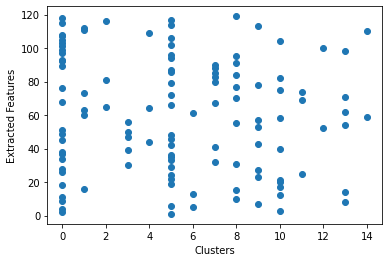

0 ['talking badly', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'items missing', 'no action', 'much disappointed', 'humble request', 'unable track', 'response complained', 'rude way', 'unable trace', 'unnecessary trouble', 'box missing', 'also complained', 'complained company', 'lame excuses', 'hard copy', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental harassment', 'misplaced transit', 'stands misplaced', 'found guilty', 'mental torture', 'going worse day']
1 ['dtdc worst', 'dtdc worst courier', 'dtdc courier worst', 'worst experience dtdc', 'courier worst', 'worst courier']
2 ['horrible experience', 'bad experience dtdc', 'bad experience']
3 ['disappointed service', 'bad customer service', 'service bad', 'horrible service', 'bad service']
4 ['complaint dtdc', 'complaint courier', 'complaint dtdc courier']
5 ['register complaint', 'reading complaint', 'consider complaint', 'gave complaint', 'company complaint', 'lodge complaint', 'com

In [ ]:
# Clusters of 15 classes
# Centroid array
# No. of emails assigned to each class
cluster_15 = email_class(print_centroids(clustering(15)))
df['cluster_15'] = cluster_15
print("Shape " , len(cluster_15))

Calinski Harabasz score:  40.06882107890309
Silhouette Score:  0.4329503670244681


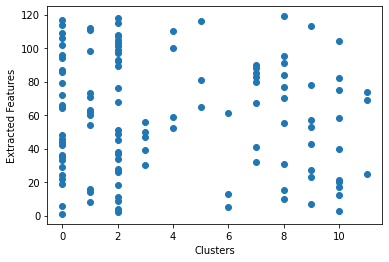

0 ['register complaint', 'reading complaint', 'consider complaint', 'gave complaint', 'company complaint', 'lodge complaint', 'complaint number', 'subject complaint', 'request investigate complaint', 'lodged complaint', 'complaint dtdc', 'investigate complaint', 'log complaint', 'complaint courier', 'consumer complaint', 'raised complaint', 'file complaint', 'complaint request', 'consumer court complaint', 'registered complaint', 'court complaint', 'complaint redressal mechanism', 'raise complaint', 'complaint dtdc courier', 'investigate complaint request', 'written complaint']
1 ['worst experience', 'worst customer care', 'dtdc worst', 'worst website', 'dtdc worst courier', 'really worst', 'dtdc courier worst', 'worst part', 'worst experience dtdc', 'worst customer', 'courier worst', 'worst courier']
2 ['talking badly', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'items missing', 'no action', 'much disappointed', 'humble request', 'unable track', 'response com

In [ ]:
# Clusters of 12 classes
# Centroid array
# No. of emails assigned to each class
cluster_12 = email_class(print_centroids(clustering(12)))
df['cluster_12'] = cluster_12

In [ ]:
#df.head()
#final_df = df[['Email','cluster_12']]
#final_df.to_csv('Final_test_top.csv',index=False)

Calinski Harabasz score:  35.602747201451486
Silhouette Score:  0.3744836135307051


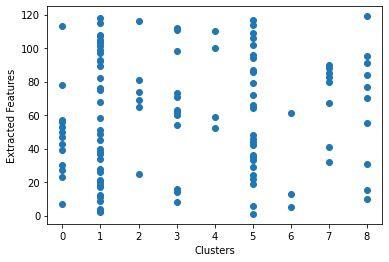

0 ['service worst service', 'worst service provider', 'courier service worst', 'disappointed service', 'bad customer service', 'worst service', 'service bad', 'horrible service', 'service worst customer', 'bad service', 'worst courier service', 'worst customer service', 'service worst']
1 ['talking badly', 'giving wrong', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'thing wrong', 'wrong address', 'items missing', 'wrong attitude', 'delivered wrong', 'no action', 'much disappointed', 'humble request', 'unable track', 'response complained', 'wrong hands', 'rude way', 'unable trace', 'unnecessary trouble', 'showing wrong', 'box missing', 'wrong place', 'also complained', 'delivered wrong address', 'complained company', 'lame excuses', 'hard copy', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental harassment', 'wrong information', 'misplaced transit', 'stands misplaced', 'found guilty', 'mental torture', 'going worse day']
2 ['bad customer',

In [ ]:
# Clusters of 9 classes
# Centroid array
# No. of emails assigned to each class
cluster_9 = email_class(print_centroids(clustering(9)))
df['cluster_9'] = cluster_9

Calinski Harabasz score:  35.51106887387512
Silhouette Score:  0.30112506863920974


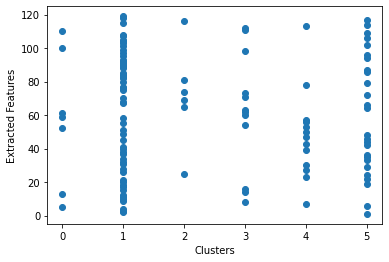

0 ['fake courier company dtdc', 'dtdc failed', 'pathetic service dtdc', 'really pathetic', 'dtdc pathetic', 'pathetic service', 'pathetic situation']
1 ['talking badly', 'giving wrong', 'mental agony', 'sender immediately destroy', 'not good', 'immediately destroy', 'thing wrong', 'not aware', 'wrong address', 'items missing', 'wrong attitude', 'delivered wrong', 'no action', 'much disappointed', 'not able', 'sorry say', 'humble request', 'unable track', 'response complained', 'wrong hands', 'sorry inform', 'rude way', 'unable trace', 'unnecessary trouble', 'not ready', 'showing wrong', 'sorry inconvenience', 'box missing', 'not willing', 'wrong place', 'also complained', 'not sure', 'sorry inform till', 'delivered wrong address', 'charge sorry inform', 'not interested', 'speed charge sorry', 'said sorry', 'complained company', 'charge sorry', 'not available', 'lame excuses', 'hard copy', 'not sure whether', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental hara

In [ ]:
# Clusters of 6 classes
# Centroid array
# No. of emails assigned to each class
cluster_6 = email_class(print_centroids(clustering(6)))
df['cluster_6'] = cluster_6

## Predicting result for test data

In [ ]:
df = df_test

Calinski Harabasz score:  37.66480366362929
Silhouette Score:  0.38429181323148925


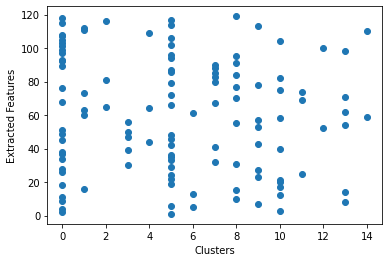

0 ['talking badly', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'items missing', 'no action', 'much disappointed', 'humble request', 'unable track', 'response complained', 'rude way', 'unable trace', 'unnecessary trouble', 'box missing', 'also complained', 'complained company', 'lame excuses', 'hard copy', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental harassment', 'misplaced transit', 'stands misplaced', 'found guilty', 'mental torture', 'going worse day']
1 ['dtdc worst', 'dtdc worst courier', 'dtdc courier worst', 'worst experience dtdc', 'courier worst', 'worst courier']
2 ['horrible experience', 'bad experience dtdc', 'bad experience']
3 ['disappointed service', 'bad customer service', 'service bad', 'horrible service', 'bad service']
4 ['complaint dtdc', 'complaint courier', 'complaint dtdc courier']
5 ['register complaint', 'reading complaint', 'consider complaint', 'gave complaint', 'company complaint', 'lodge complaint', 'com

In [ ]:
# Clusters of 15 classes
# Centroid array
# No. of emails assigned to each class
cluster_15 = email_class(print_centroids(clustering(15)))
df['cluster_15'] = cluster_15

Calinski Harabasz score:  40.06882107890309
Silhouette Score:  0.4329503670244681


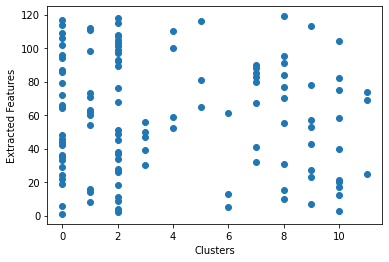

0 ['register complaint', 'reading complaint', 'consider complaint', 'gave complaint', 'company complaint', 'lodge complaint', 'complaint number', 'subject complaint', 'request investigate complaint', 'lodged complaint', 'complaint dtdc', 'investigate complaint', 'log complaint', 'complaint courier', 'consumer complaint', 'raised complaint', 'file complaint', 'complaint request', 'consumer court complaint', 'registered complaint', 'court complaint', 'complaint redressal mechanism', 'raise complaint', 'complaint dtdc courier', 'investigate complaint request', 'written complaint']
1 ['worst experience', 'worst customer care', 'dtdc worst', 'worst website', 'dtdc worst courier', 'really worst', 'dtdc courier worst', 'worst part', 'worst experience dtdc', 'worst customer', 'courier worst', 'worst courier']
2 ['talking badly', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'items missing', 'no action', 'much disappointed', 'humble request', 'unable track', 'response com

In [ ]:
# Clusters of 12 classes
# Centroid array
# No. of emails assigned to each class
cluster_12 = email_class(print_centroids(clustering(12)))
df['cluster_12'] = cluster_12

Calinski Harabasz score:  35.602747201451486
Silhouette Score:  0.3744836135307051


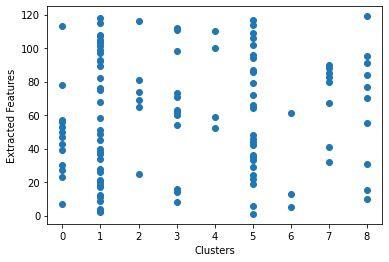

0 ['service worst service', 'worst service provider', 'courier service worst', 'disappointed service', 'bad customer service', 'worst service', 'service bad', 'horrible service', 'service worst customer', 'bad service', 'worst courier service', 'worst customer service', 'service worst']
1 ['talking badly', 'giving wrong', 'mental agony', 'sender immediately destroy', 'immediately destroy', 'thing wrong', 'wrong address', 'items missing', 'wrong attitude', 'delivered wrong', 'no action', 'much disappointed', 'humble request', 'unable track', 'response complained', 'wrong hands', 'rude way', 'unable trace', 'unnecessary trouble', 'showing wrong', 'box missing', 'wrong place', 'also complained', 'delivered wrong address', 'complained company', 'lame excuses', 'hard copy', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental harassment', 'wrong information', 'misplaced transit', 'stands misplaced', 'found guilty', 'mental torture', 'going worse day']
2 ['bad customer',

In [ ]:
# Clusters of 9 classes
# Centroid array
# No. of emails assigned to each class
cluster_9 = email_class(print_centroids(clustering(9)))
df['cluster_9'] = cluster_9

Calinski Harabasz score:  35.51106887387512
Silhouette Score:  0.30112506863920974


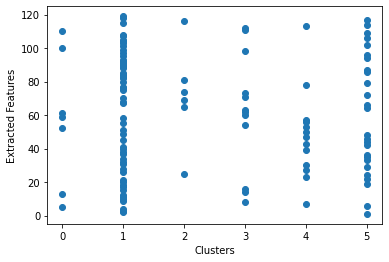

0 ['fake courier company dtdc', 'dtdc failed', 'pathetic service dtdc', 'really pathetic', 'dtdc pathetic', 'pathetic service', 'pathetic situation']
1 ['talking badly', 'giving wrong', 'mental agony', 'sender immediately destroy', 'not good', 'immediately destroy', 'thing wrong', 'not aware', 'wrong address', 'items missing', 'wrong attitude', 'delivered wrong', 'no action', 'much disappointed', 'not able', 'sorry say', 'humble request', 'unable track', 'response complained', 'wrong hands', 'sorry inform', 'rude way', 'unable trace', 'unnecessary trouble', 'not ready', 'showing wrong', 'sorry inconvenience', 'box missing', 'not willing', 'wrong place', 'also complained', 'not sure', 'sorry inform till', 'delivered wrong address', 'charge sorry inform', 'not interested', 'speed charge sorry', 'said sorry', 'complained company', 'charge sorry', 'not available', 'lame excuses', 'hard copy', 'not sure whether', 'immediately destroy copies', 'false promises', 'parcel missing', 'mental hara

In [ ]:
# Clusters of 6 classes
# Centroid array
# No. of emails assigned to each class
cluster_6 = email_class(print_centroids(clustering(6)))
df['cluster_6'] = cluster_6